# Visualizing Trend



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,10]


When making scatter plots or time series, we are often more interested in the overarching **trend** of the data than in the specific detail of where each individual data point lies. By drawing the trend on top of or instead of the actual data points, usually in the form of a straight or curved line, we can create a visualization that helps the reader immediately see key features of the data.


There are two fundamental approaches to determining a trend: We can either **smooth** the data, such as a moving average, that we discussed in timeseries lecture or we can **fit a curve with a defined functional form** and then draw the fitted curve.

## Smoothing

In [47]:
series = pd.read_csv('daily-min-temperatures.csv', header=0, parse_dates= True, index_col= 0)
series.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


### 1- Smoothing using Moving Average (recall from timeseries data)

The act of smoothing produces a function that captures key patterns in the data while removing irrelevant minor detail or noise. Financial analysts usually smooth stock-market data by calculating moving averages. To generate a moving average, we take a time window, say the first 20 days in the time series, calculate the average price over these 20 days, then move the time window by one day, so it now spans the 2nd to 21st day, calculate the average over these 20 days, move the time window again, and so on. The result is a new time series consisting of a sequence of averaged prices.



''

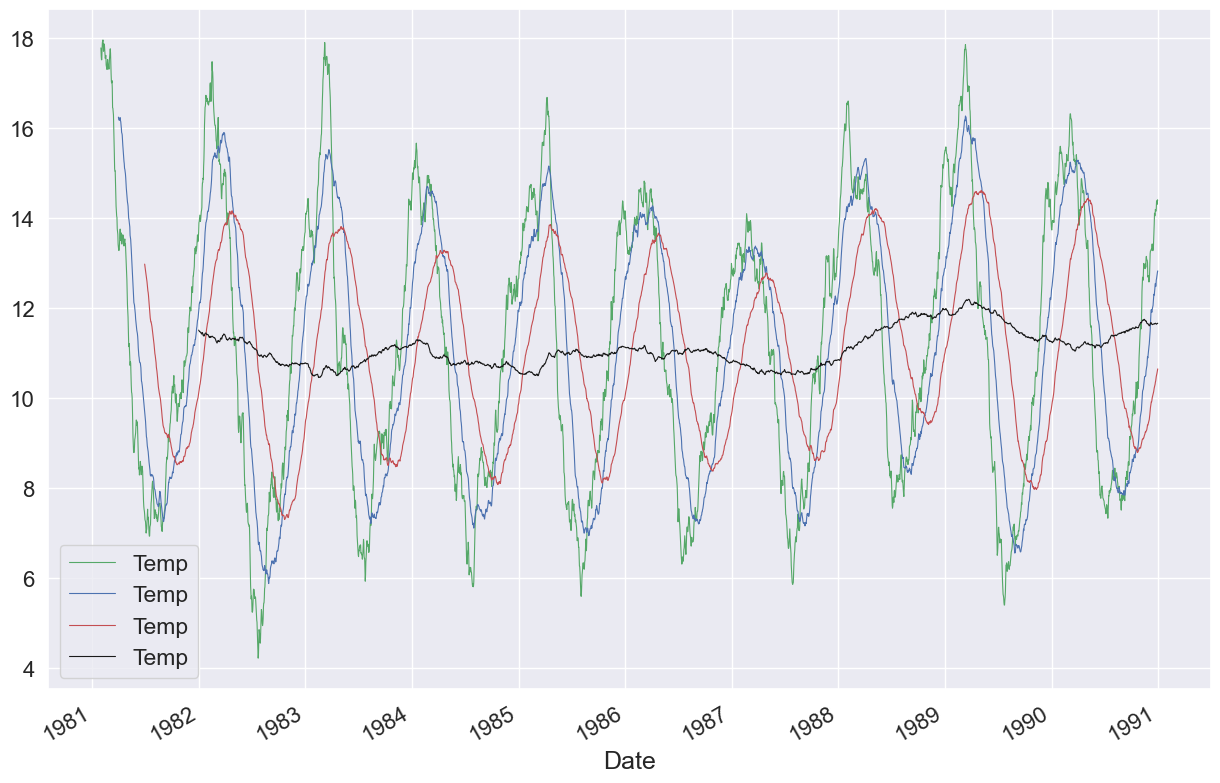

In [51]:
# Seasonal moving average
ma_30 = series.rolling(window=30).mean()
ma_90 = series.rolling(window=90).mean()
ma_180 = series.rolling(window=180).mean()
ma_365 = series.rolling(window=365).mean()
ax = ma_30.plot(linewidth=0.8, fontsize=16, c= 'g')
ma_90.plot(linewidth=0.8, fontsize=16, c= 'b', ax= ax)
ma_180.plot(linewidth=0.8, fontsize=16, c= 'r', ax= ax)
ma_365.plot(linewidth=0.8, fontsize=16, c= 'k', ax= ax)
;

let's look at [Dow Jones Industrial Average Historical Data](https://www.kaggle.com/datasets/mnassrib/dow-jones-industrial-average?select=Dow+Jones+Industrial+Average+Historical+Data.csv) 

In [14]:
dow = pd.read_csv('DowJones Price.csv', header=0,parse_dates= True, index_col= 0).iloc[::-1]
dow.head()

,price_int
Date,
2009-01-05,8952.89
2009-01-06,9015.10
2009-01-07,8769.70
2009-01-08,8742.46
2009-01-09,8599.18


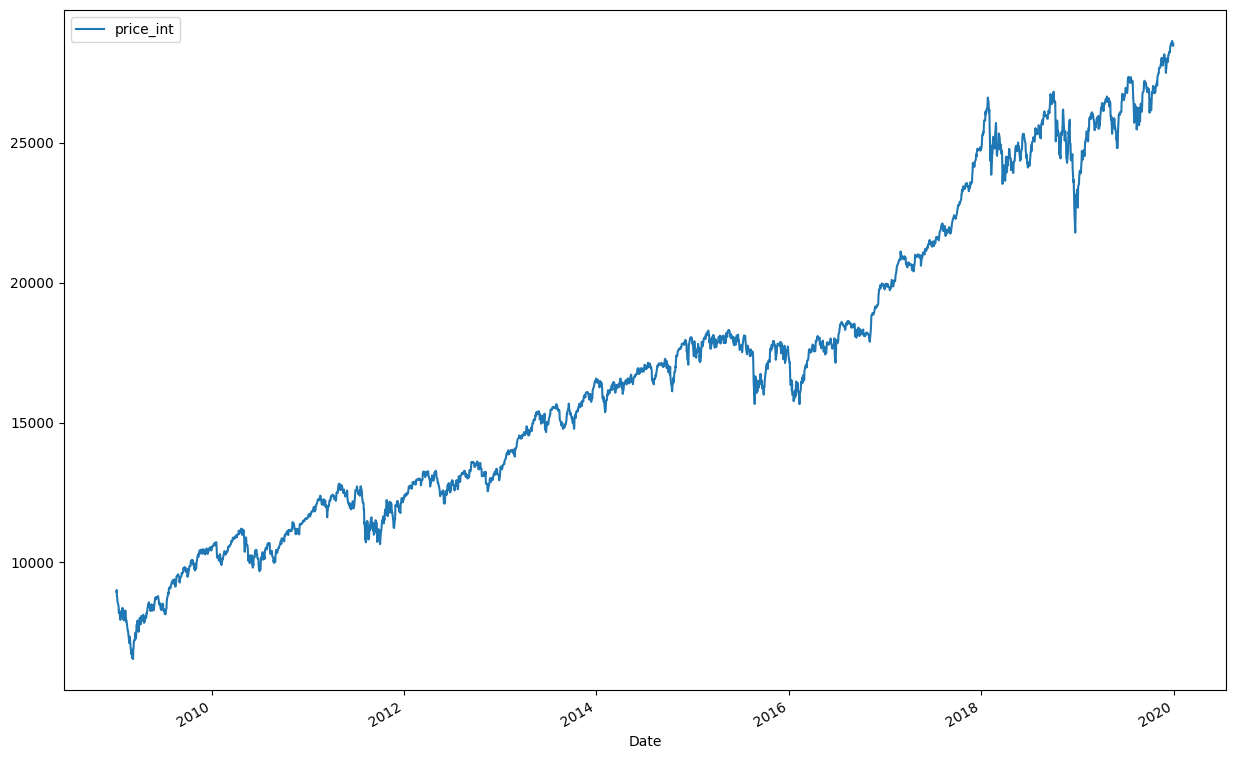

In [16]:
dow.plot();

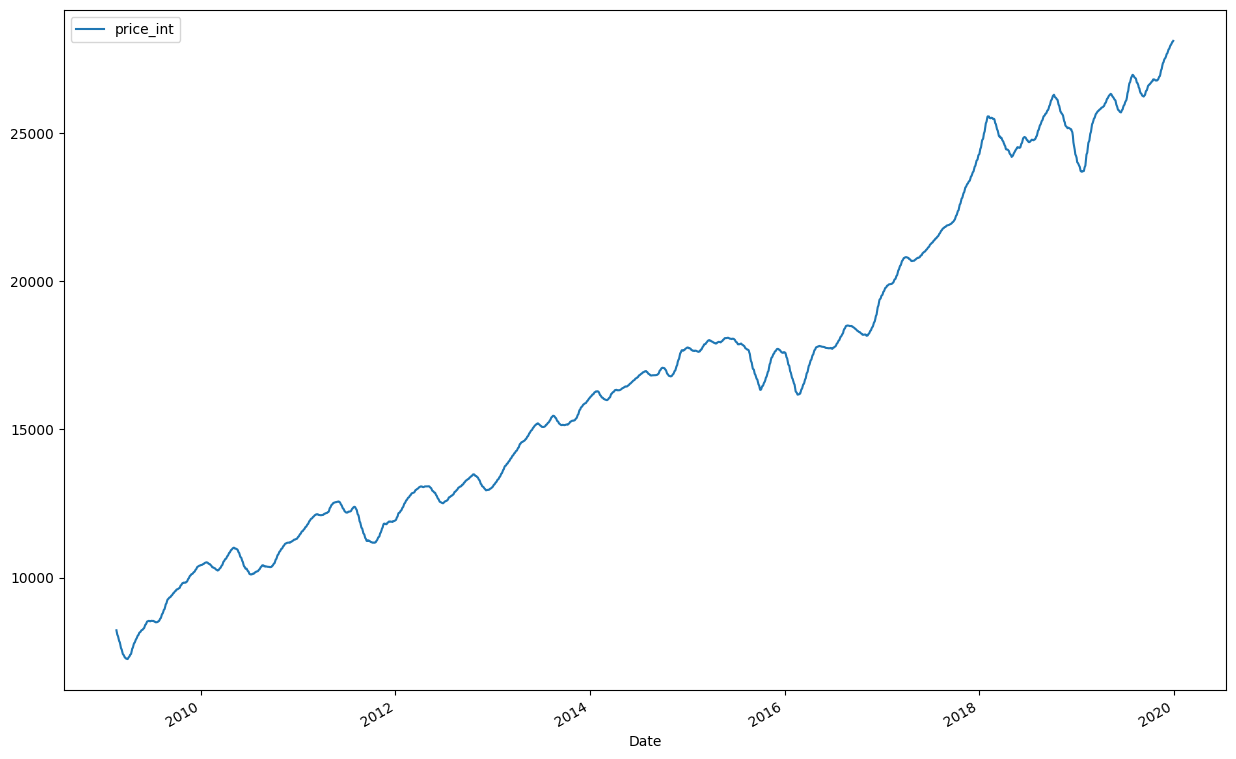

In [18]:
dow.rolling(window= 30).mean().plot();

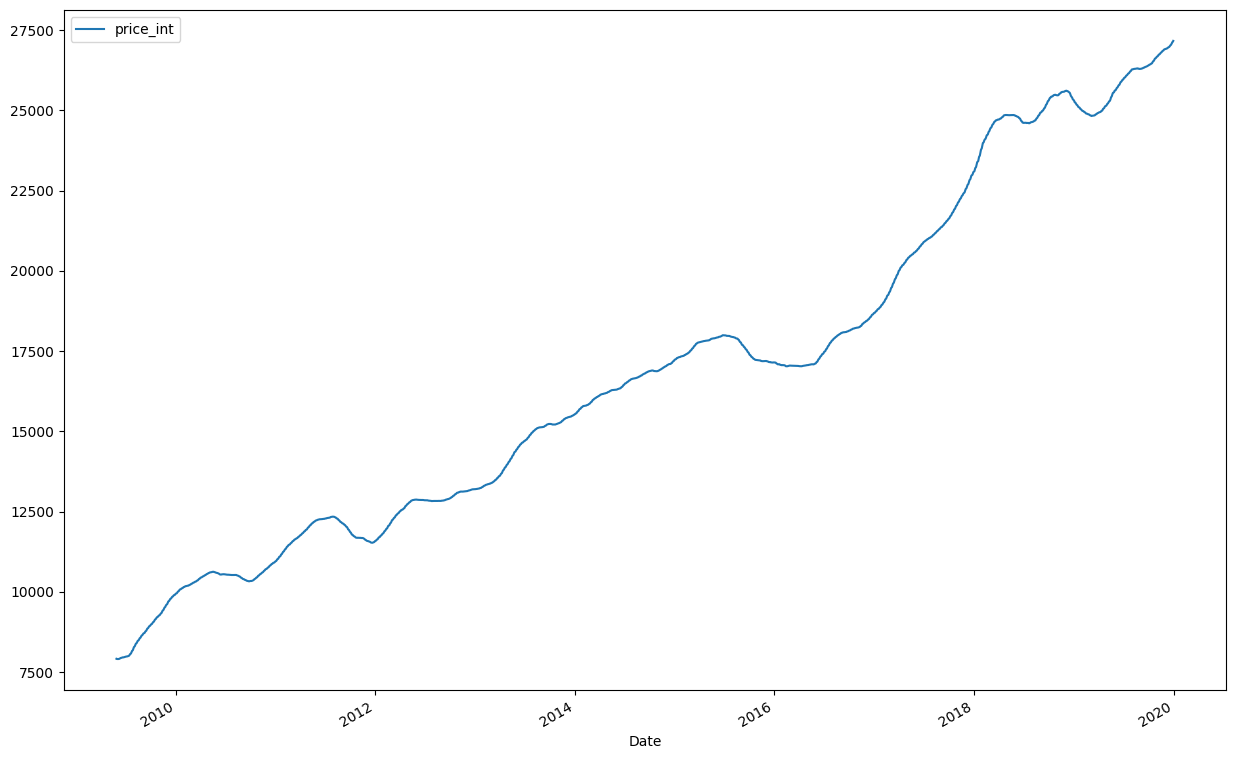

In [20]:
dow.rolling(window= 100).mean().plot();

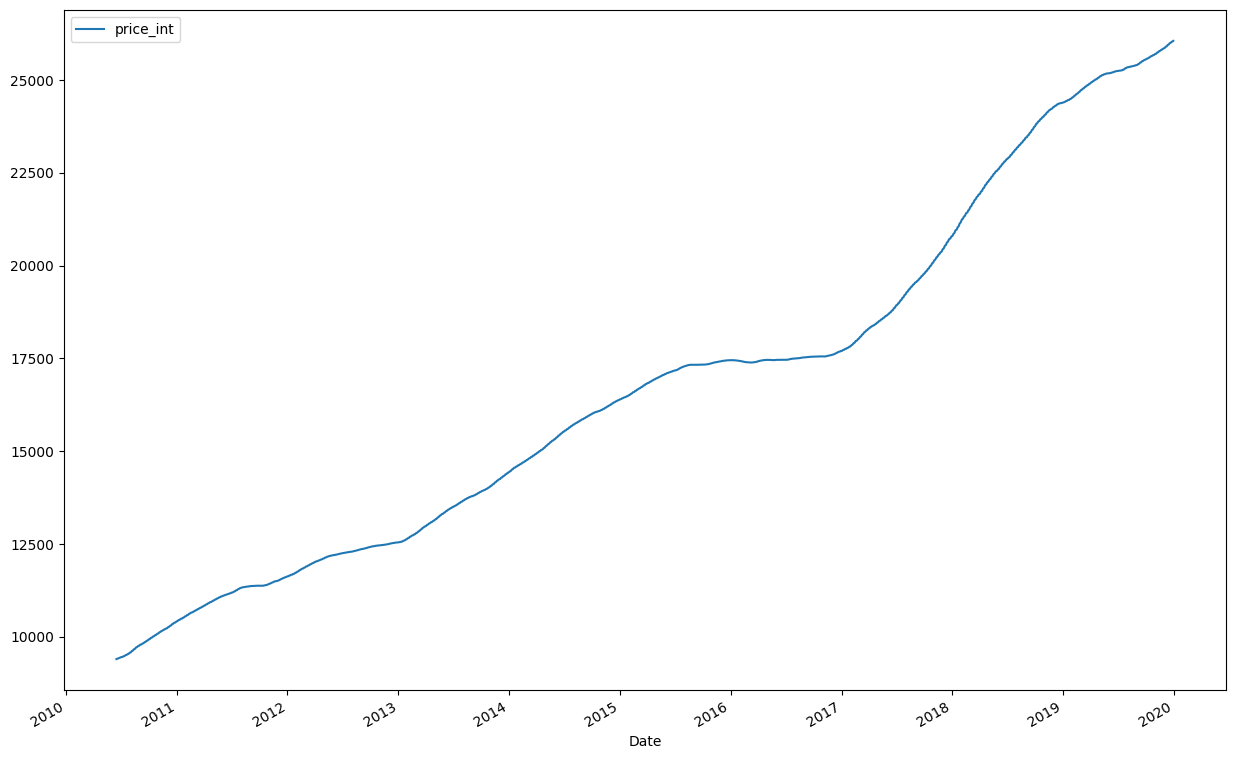

In [22]:
dow.rolling(window= 365).mean().plot();

## Discussion:
What is the drawback of moving average?

First, it results in a smoothed curve that is shorter than the original curve
Second, even with a large averaging window, a moving average is not necessarily that smooth. It may exhibit small bumps and wiggles even though larger-scale smoothing has been achieved
These wiggles are caused by individual data points that enter or exit the averaging window. Since all data points in the window are weighted equally, individual data points at the window boundaries can have visible impact on the average.



One widely used method to fix this drawbacks is LOWESS (Locally Weighted Scatterplot Smoothing), which fits **low-degree polynomials** to subsets of the data. Importantly, the points in the center of each subset are weighted more heavily than points at the boundaries, and this weighting scheme yields a much smoother result than we get from a weighted average

In [58]:
dow_1 = pd.read_csv('DowJones Price.csv', header=0, parse_dates= True).iloc[::-1]
dow_1['Date'] = pd.to_datetime(dow_1.Date)
dow_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2766 entries, 2765 to 0
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2766 non-null   datetime64[ns]
 1   price_int  2766 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 43.3 KB


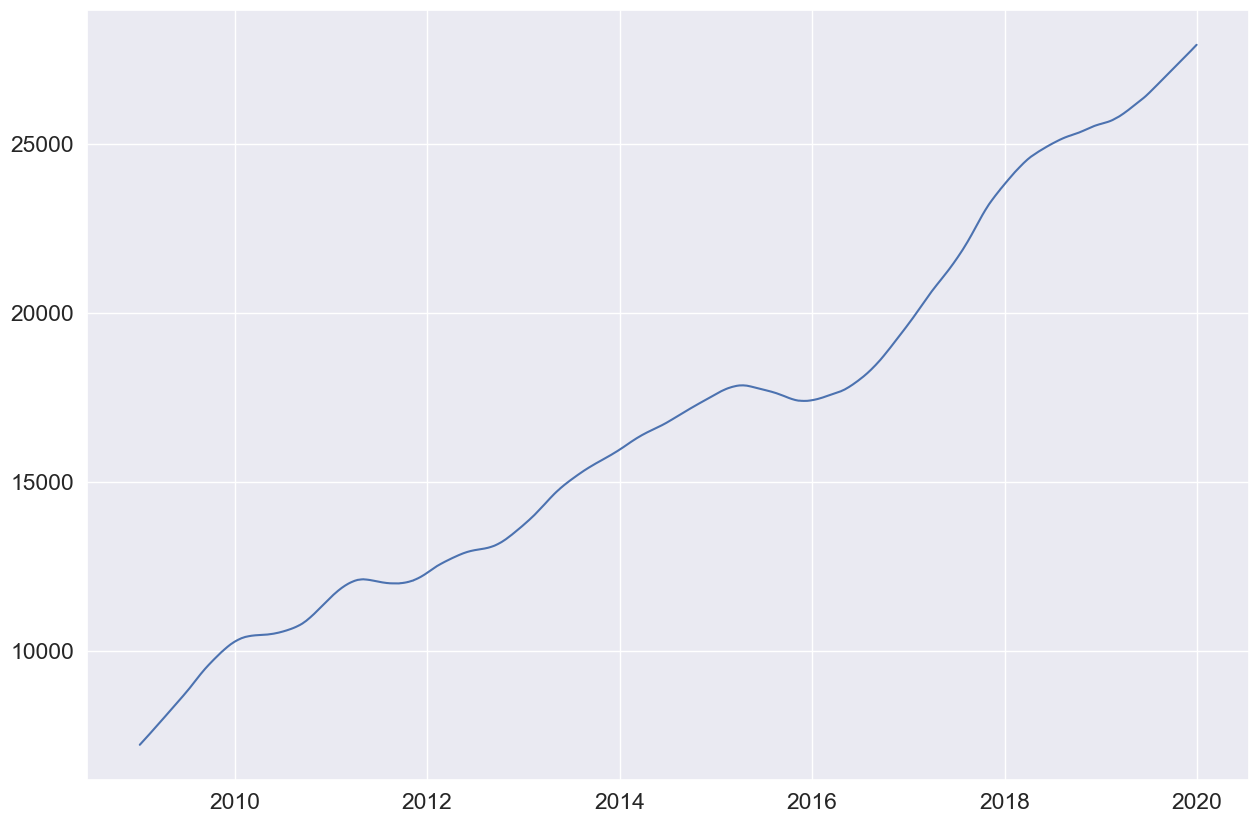

In [64]:
import statsmodels.api as sm
lowess_dow = sm.nonparametric.lowess
smoothed_dow = lowess_dow(dow_1['price_int'], dow_1['Date'], frac= 0.1)
plt.plot(dow_1['Date'], smoothed_dow[:,1], 'b');

Importantly, LOWESS is not limited to time series. It can be applied to arbitrary scatter plots, as is apparent from its name, locally estimated scatterplot smoothing.

In [66]:
import seaborn as sns
cars = sns.load_dataset('mpg')[['weight', 'mpg']]
cars= cars.groupby('weight').mean().reset_index()

In [68]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  351 non-null    int64  
 1   mpg     351 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.6 KB


In [70]:
cars

,weight,mpg
0,1613,35.0
1,1649,31.0
2,1755,39.1
3,1760,35.1
4,1773,31.0
...,...,...
346,4951,12.0
347,4952,12.0
348,4955,12.0
349,4997,11.0


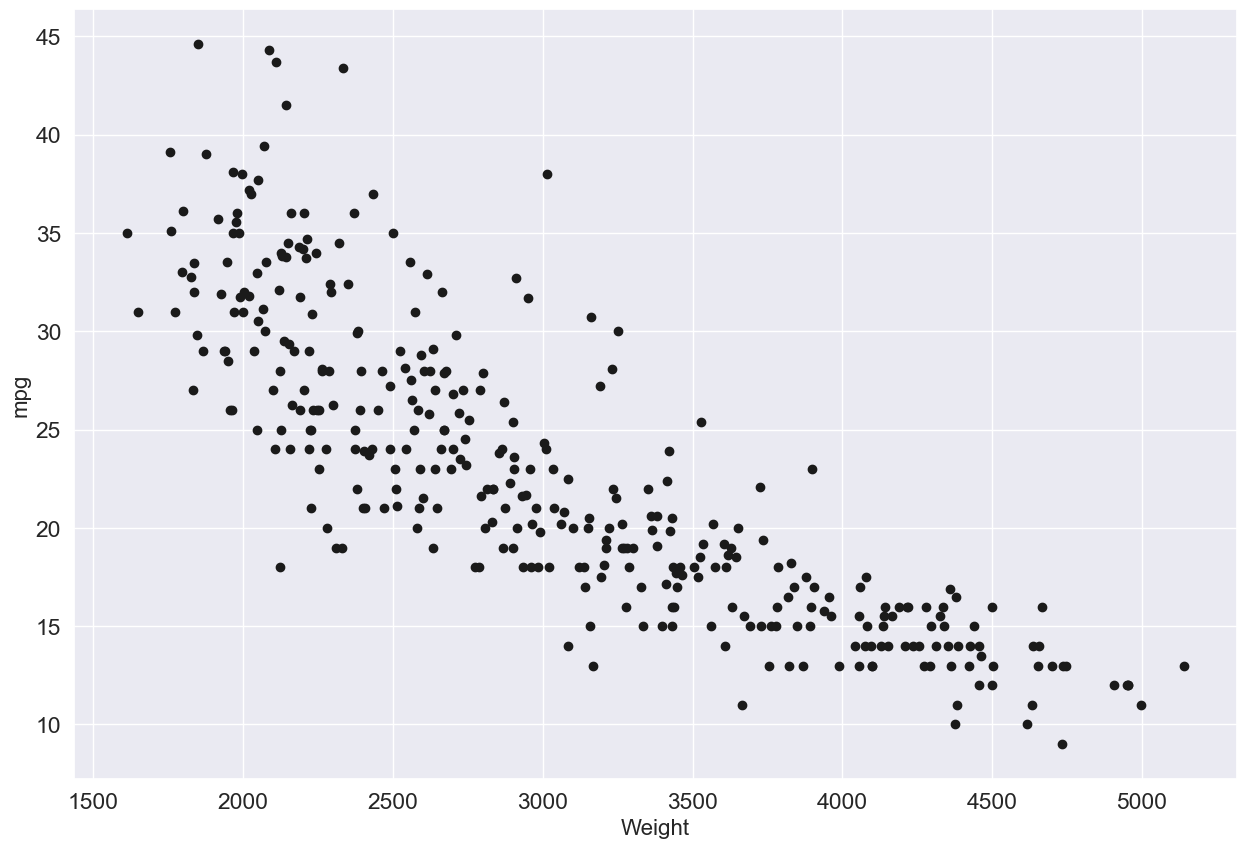

In [72]:
plt.scatter(cars['weight'], cars['mpg'], color='k')
plt.xlabel('Weight', fontsize= 16)
plt.ylabel('mpg', fontsize= 16);

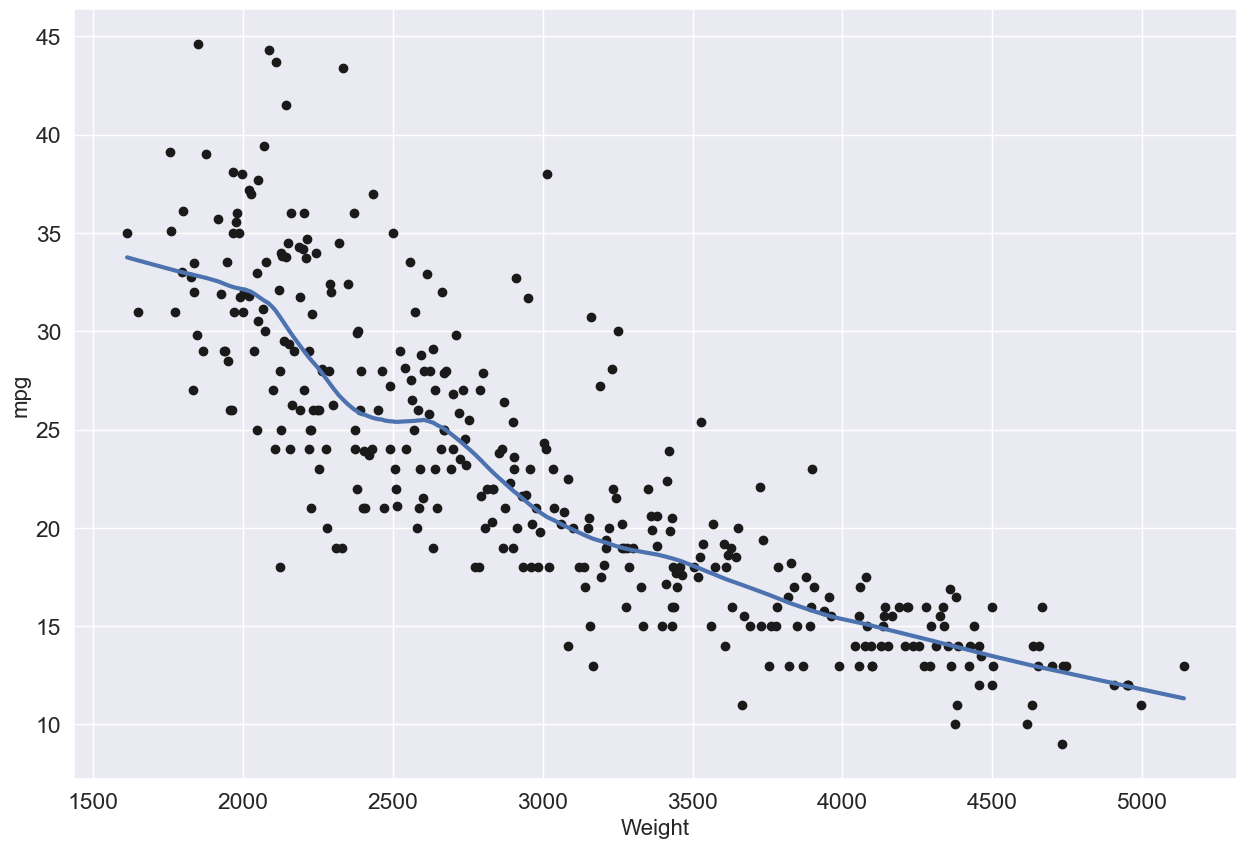

In [80]:
lowess_car = sm.nonparametric.lowess
smoothed_car = lowess_car(cars['mpg'], cars['weight'], frac= 0.2)
plt.scatter(cars['weight'], cars['mpg'], color='k')
plt.plot(smoothed_car[:,0], smoothed_car[:,1], 'b', linewidth= 3)
plt.xlabel('Weight', fontsize= 16)
plt.ylabel('mpg', fontsize= 16);

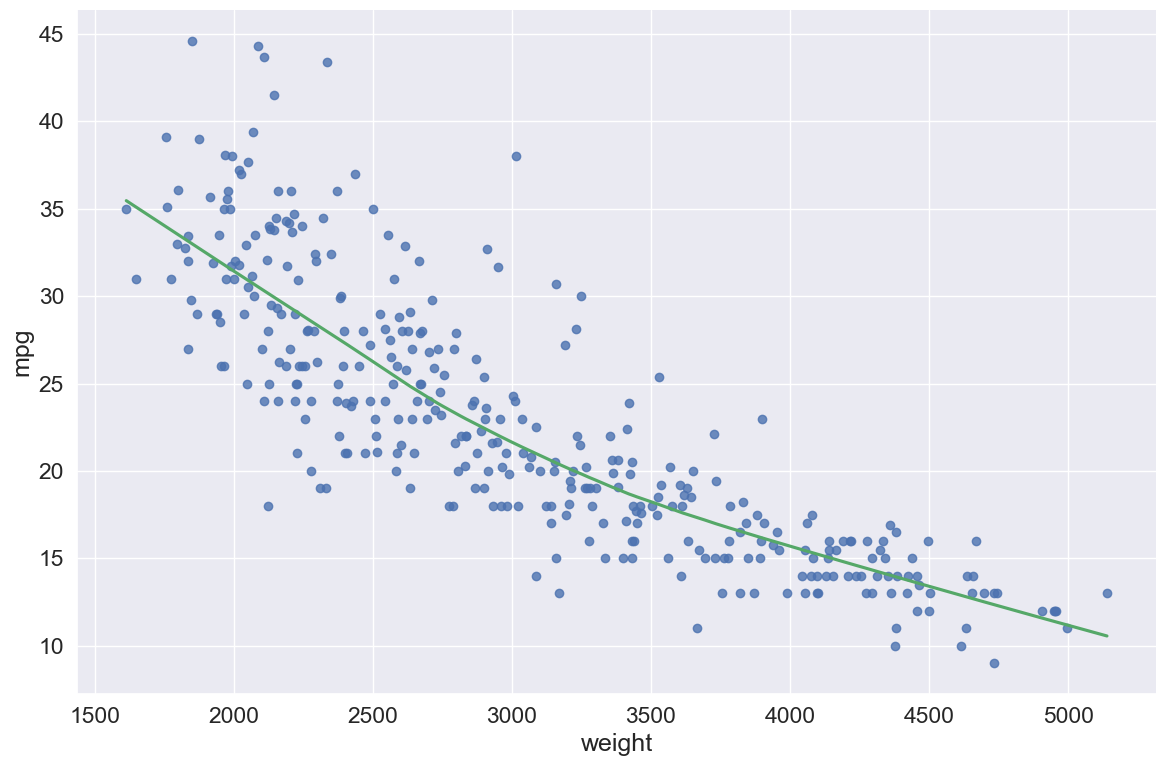

In [88]:
sns.set(font_scale=1.5)
sns.lmplot(x ='weight', y ='mpg', data = cars, height= 8, aspect= 1.5, line_kws={'color': 'g'}, lowess= True);

LOWESS is a very popular smoothing approach because it tends to produce results that look right to the human eye. However, it requires the fitting of many separate regression models. This makes it slow for large datasets, even on modern computing equipment.

As a faster alternative to LOWESS, we can use spline models. A spline is a [piecewise polynomial function](https://docs.scipy.org/doc/scipy/tutorial/interpolate/splines_and_polynomials.html) that is highly flexible yet always looks smooth. When working with splines, we will encounter the term knot. The knots in a spline are the endpoints of the individual spline segments. If we fit a spline with k segments, we need to specify k + 1 knots. While spline fitting is computationally efficient, in particular if the number of knots is not too large, splines have their own downsides. Most importantly, there is a bewildering array of different types of splines, including cubic splines, B-splines, thin-plate splines, Gaussian process splines, and many others, and which one to pick may not be obvious. The specific choice of the type of spline and number of knots used can result in widely different smoothing functions for the same data

**Be careful when interpreting the results from a smoothing function. The same dataset can be smoothed in many different ways.**

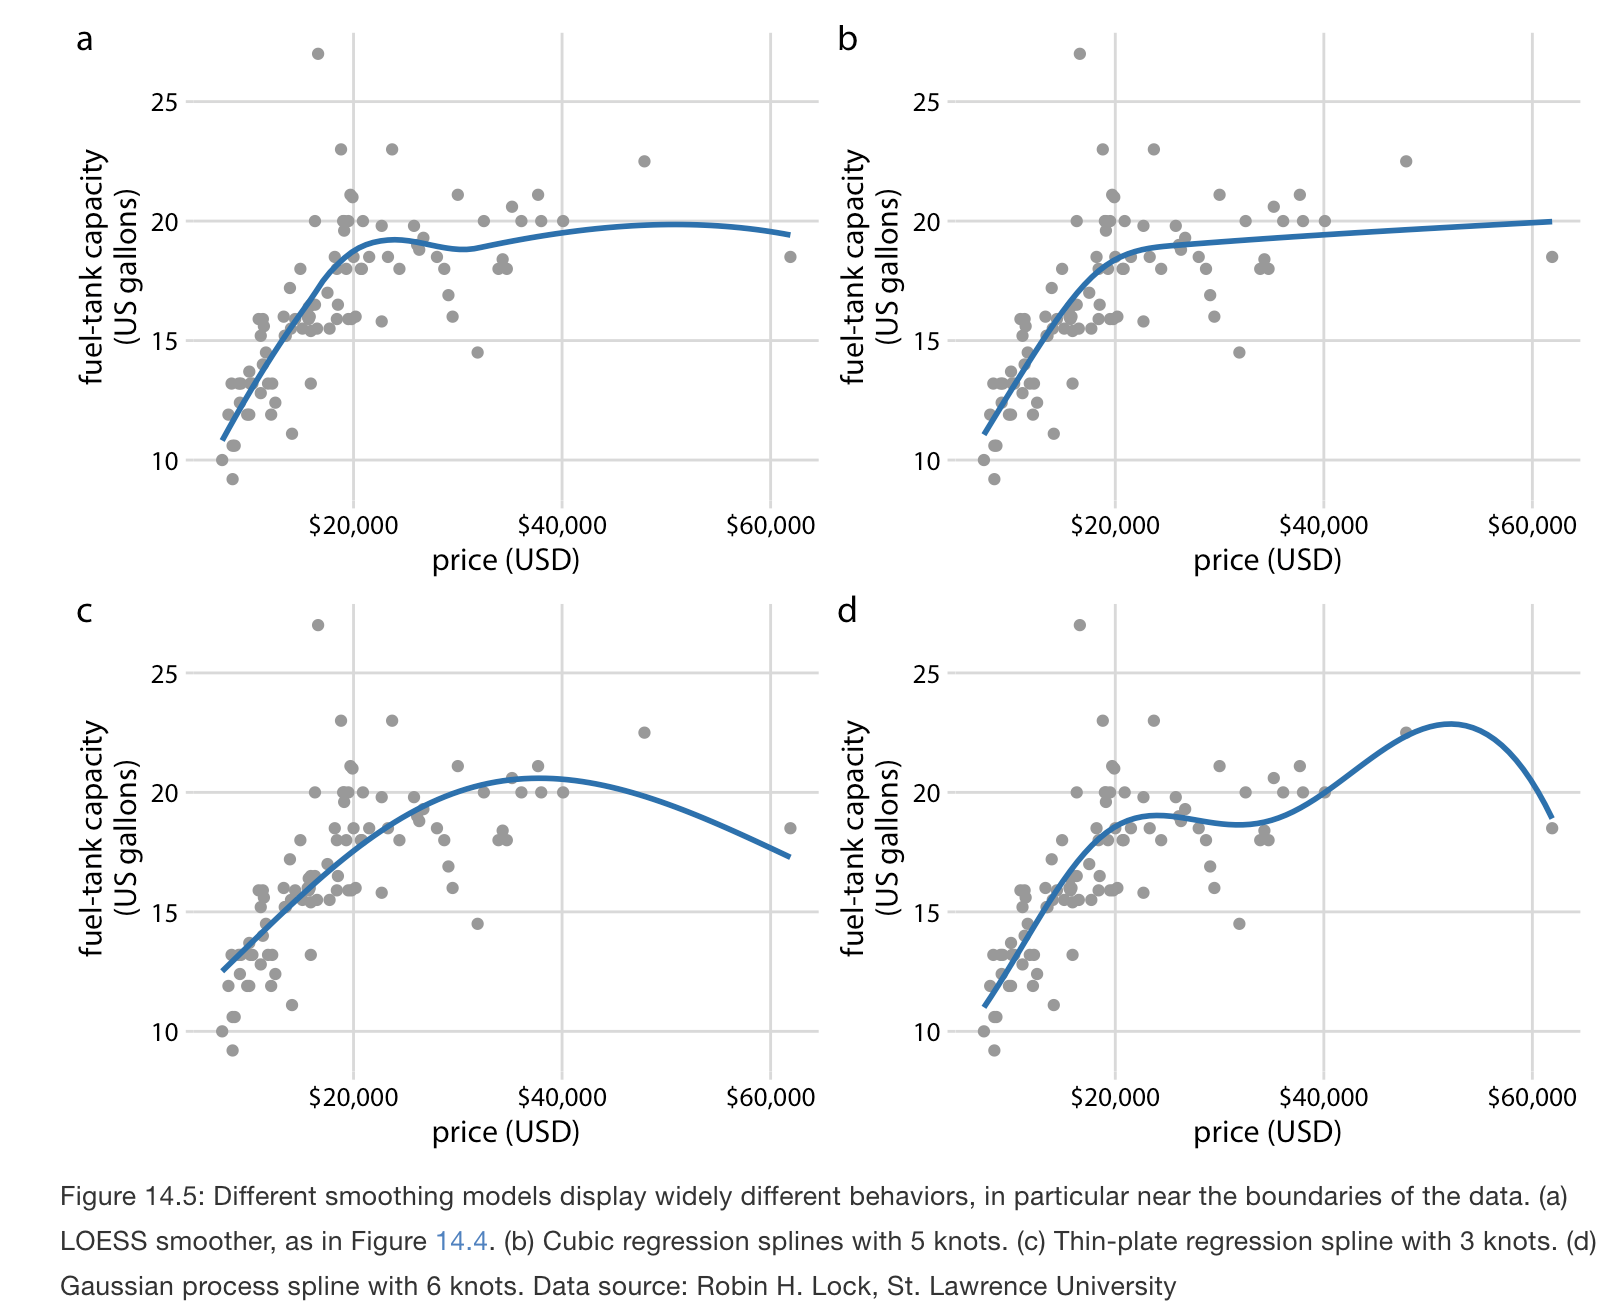

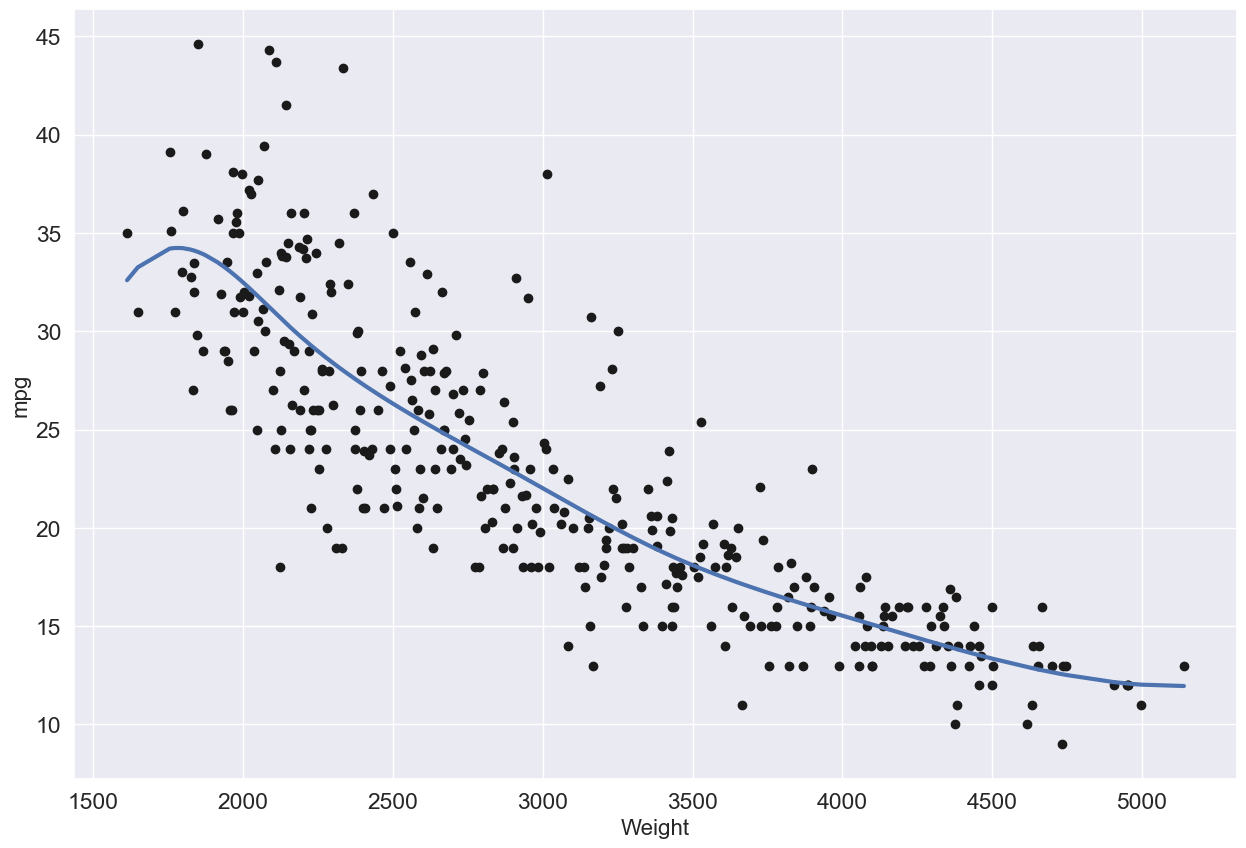

In [32]:
from scipy.interpolate import BSpline, splrep, splev

# Fit Bspline
n_interior_knots = 5
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(cars['weight'], qs)
tck = splrep(cars['weight'], cars['mpg'], t=knots, k=3)
y_smooth = BSpline(*tck)(cars['weight'])

# Display
plt.scatter(cars['weight'], cars['mpg'], color= 'k')
plt.plot(cars['weight'], y_smooth,  linewidth= 3, color= 'b')
plt.xlabel('Weight', fontsize= 16)
plt.ylabel('mpg', fontsize= 16);
plt.show()

## Showing trends with a defined functional form

As we can in this examples, the behavior of general-purpose smoothers can be somewhat unpredictable for any given dataset. These smoothers also do not provide **parameter estimates** that have a meaningful interpretation. Therefore, whenever possible, it is preferable to fit a curve with a specific functional form that is appropriate for the data and that uses parameters with clear meaning.

In [75]:
# load the dataset
tip_df = sns.load_dataset('tips')


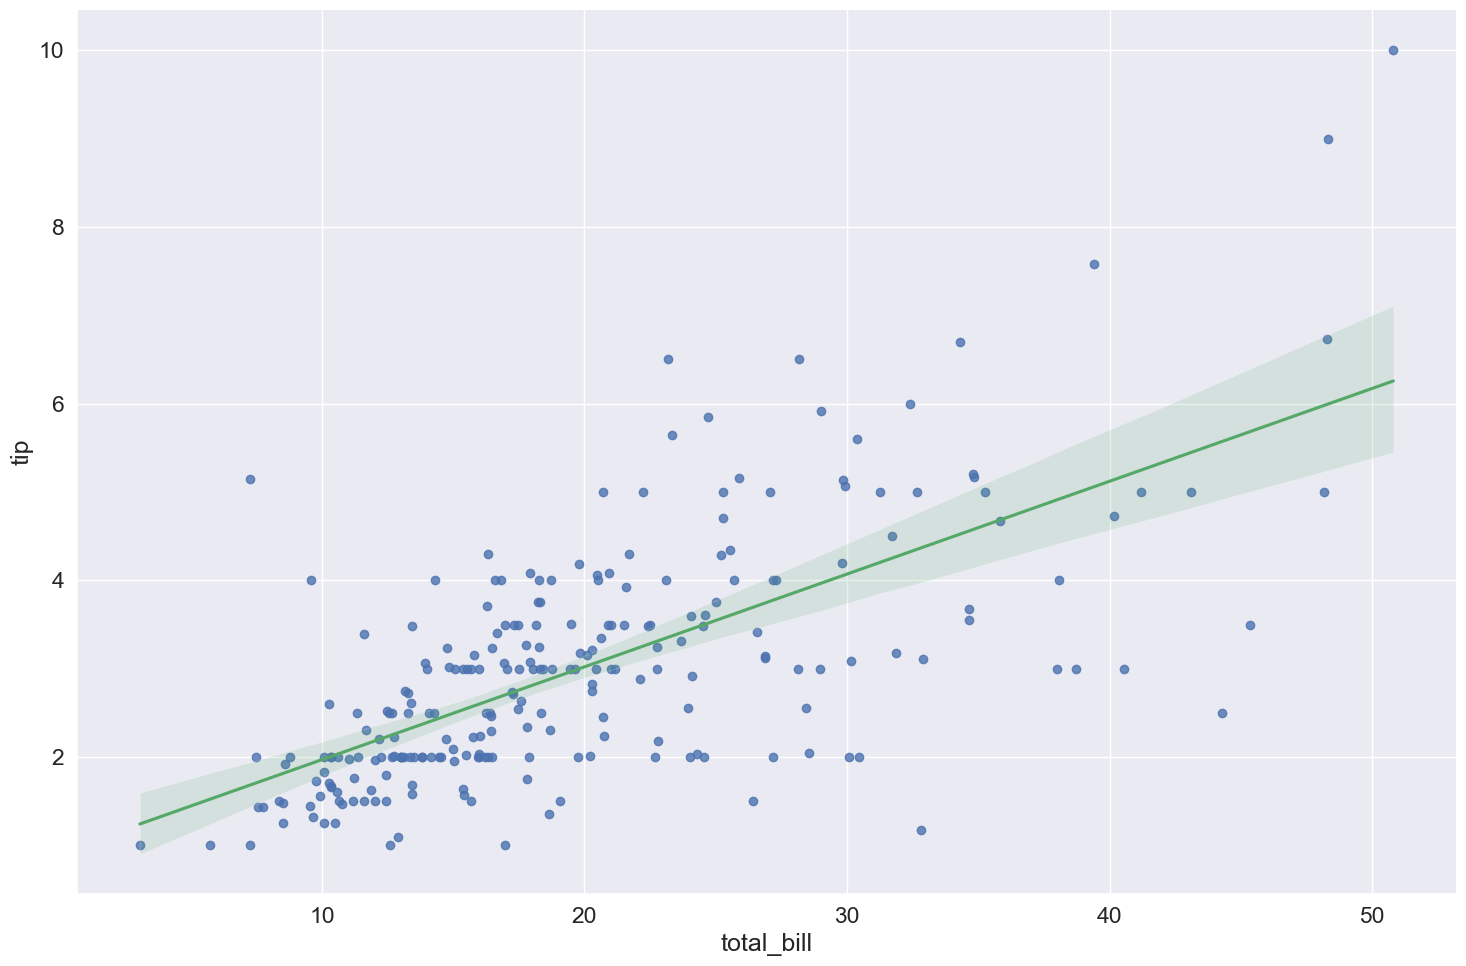

In [77]:
sns.set(font_scale=1.5)
sns.lmplot(x ='total_bill', y ='tip', data = tip_df, height= 10, aspect= 1.5, line_kws={'color': 'g'});

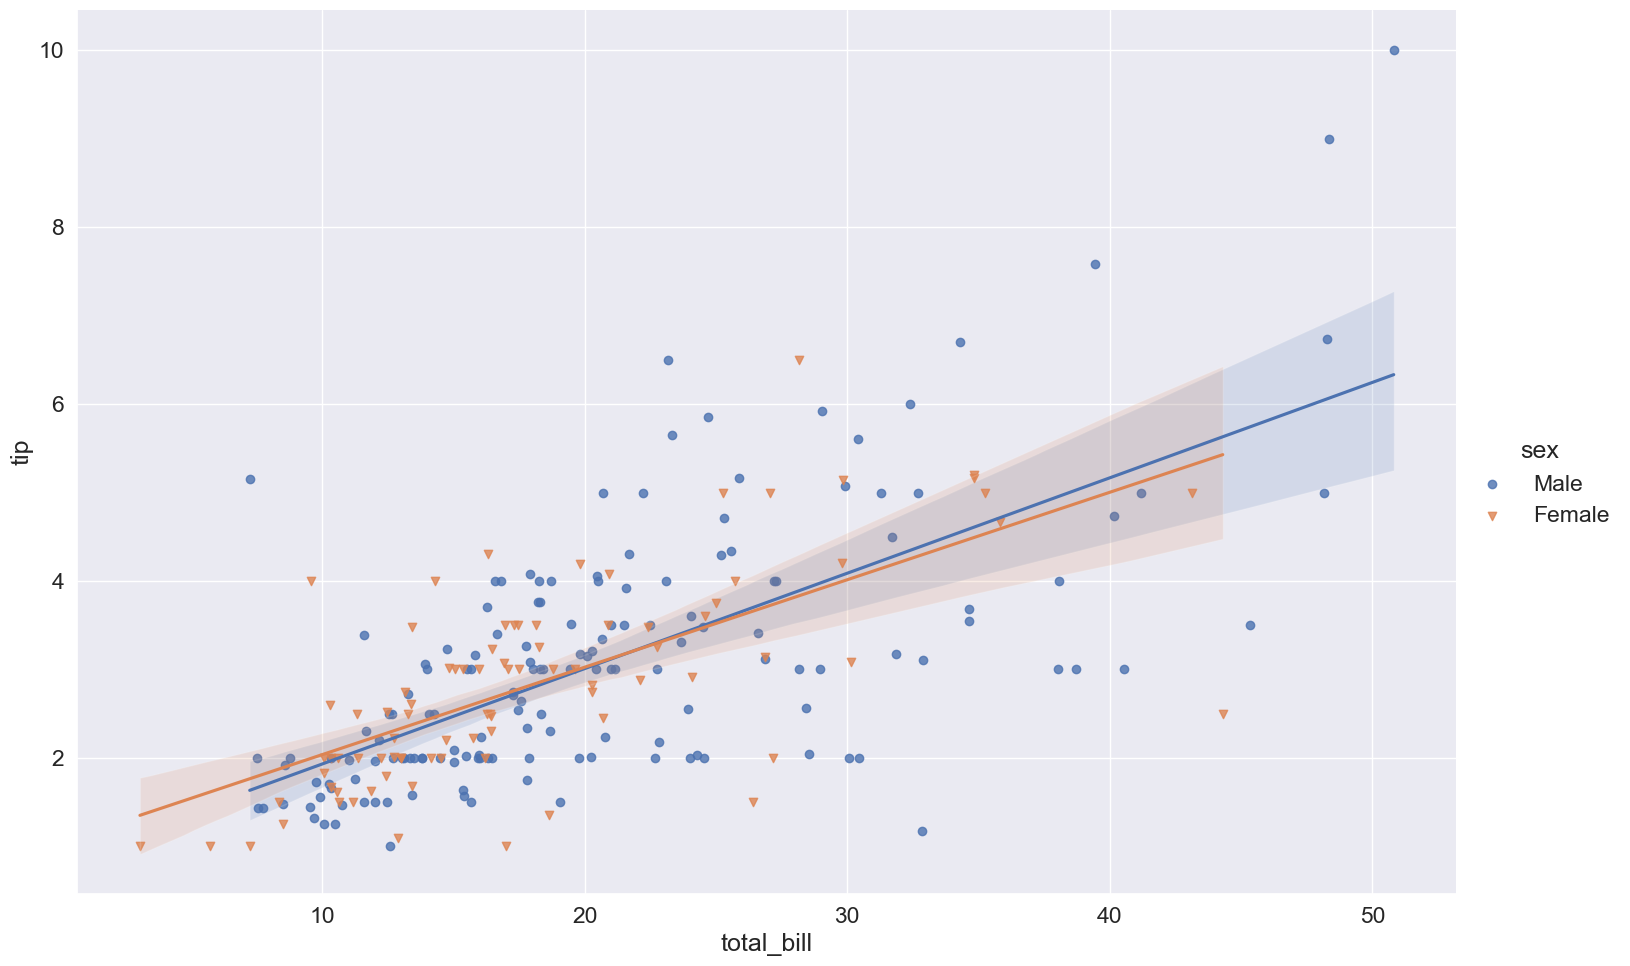

In [36]:
sns.lmplot(x ='total_bill', y ='tip', data = tip_df, hue ='sex', markers =['o', 'v'], height= 10, aspect= 1.5);

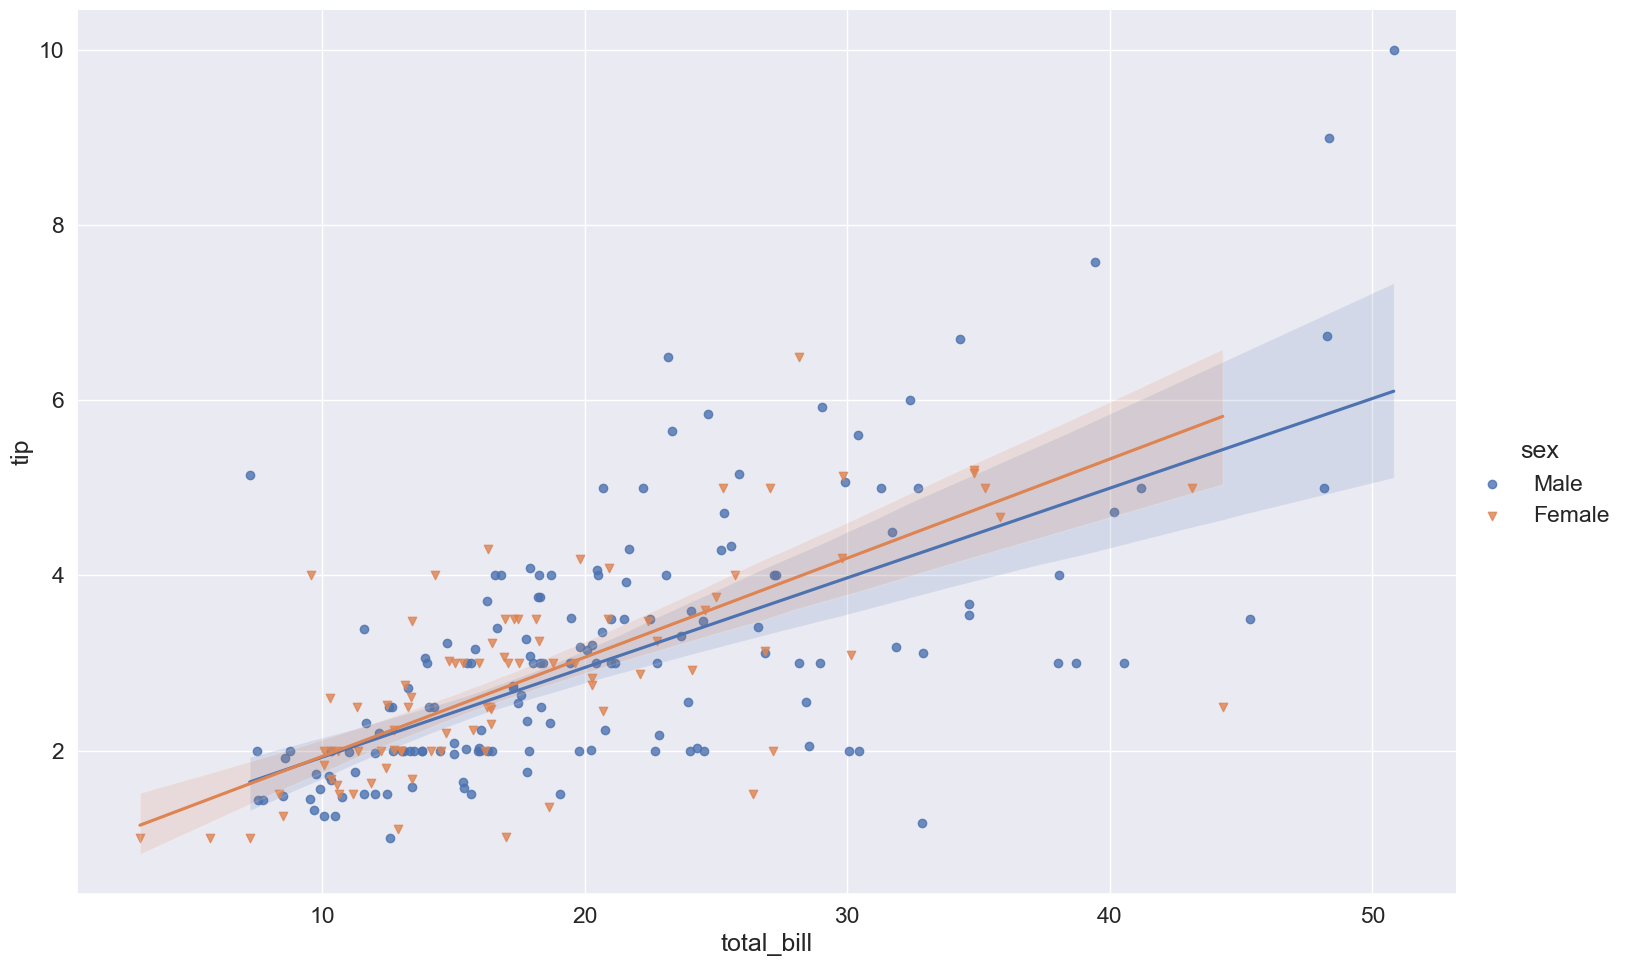

In [38]:
sns.lmplot(x ='total_bill', y ='tip', data = tip_df, hue ='sex', markers =['o', 'v'], height= 10, aspect= 1.5, robust= True);

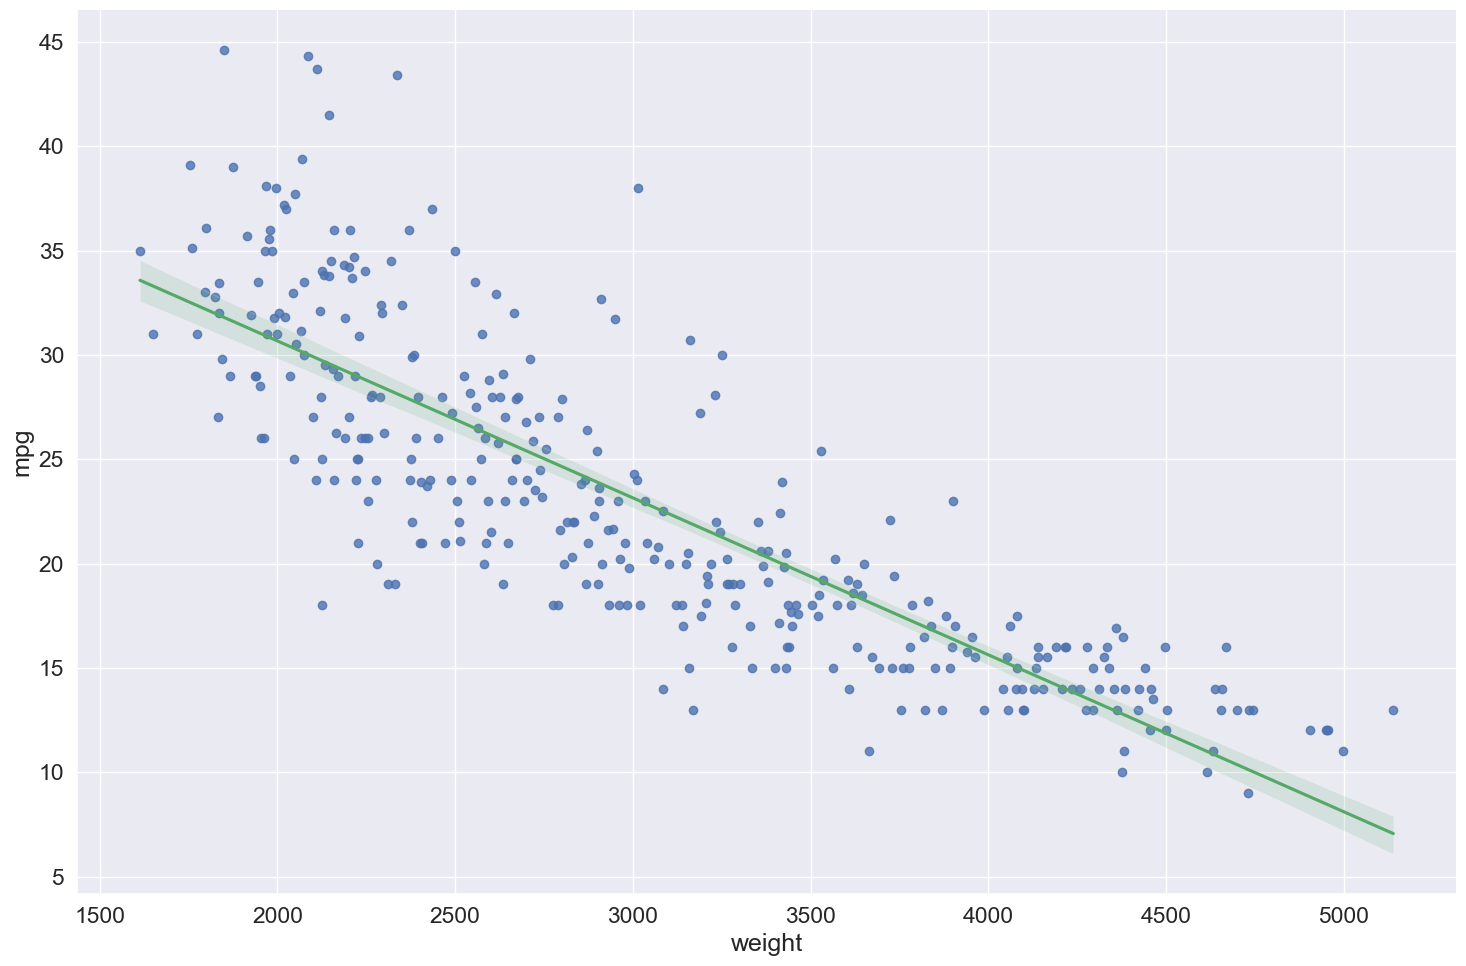

In [39]:
sns.set(font_scale=1.5)
sns.lmplot(x ='weight', y ='mpg', data = cars, height= 10, aspect= 1.5, line_kws={'color': 'g'});

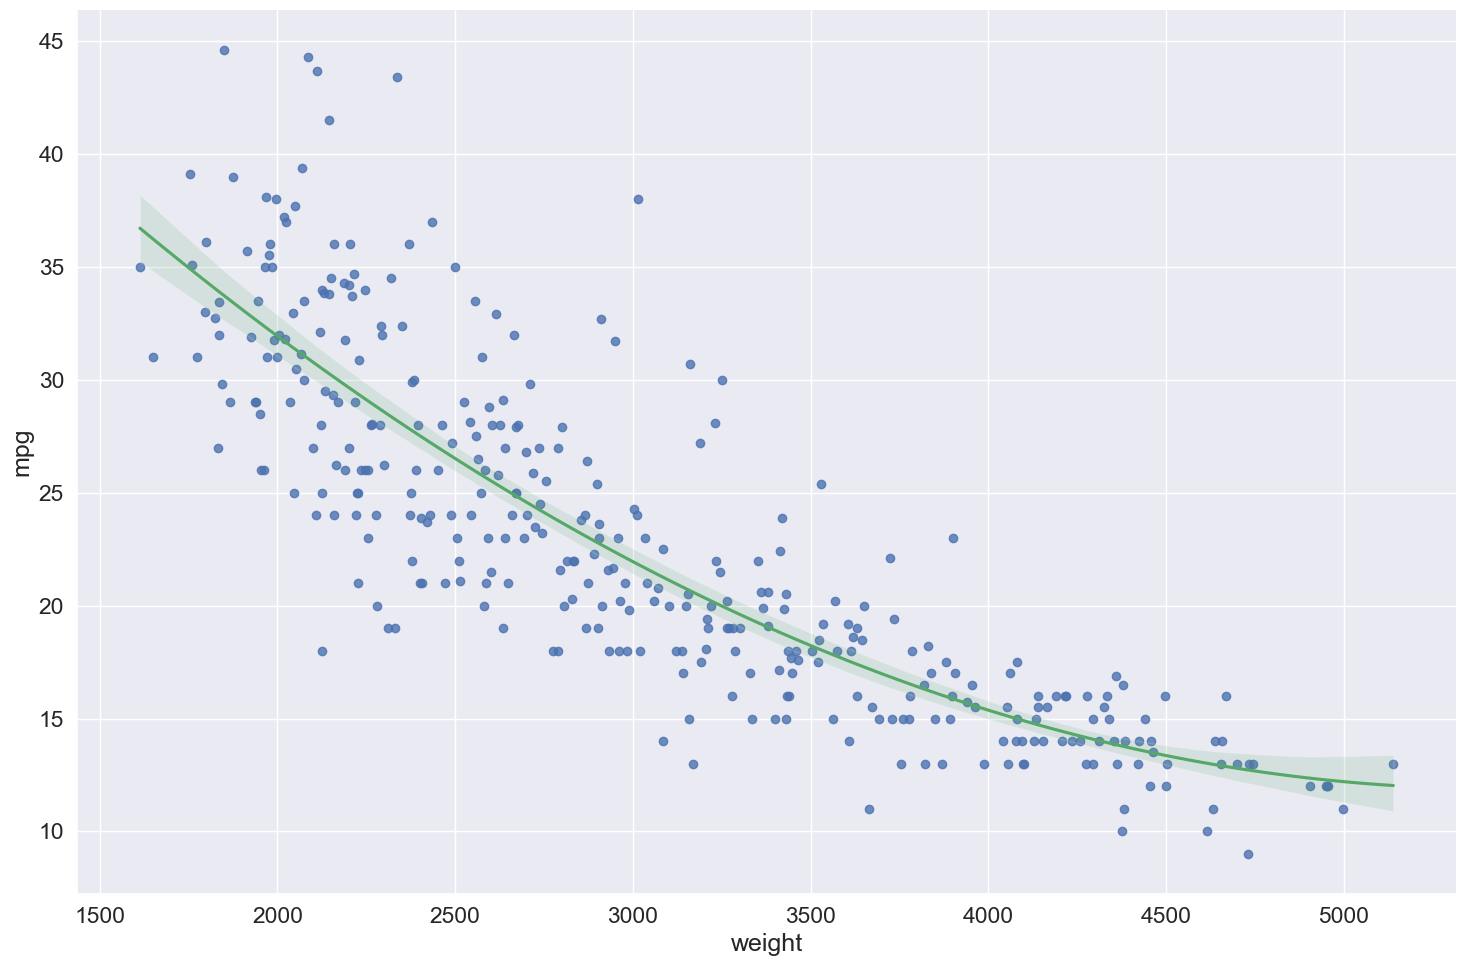

In [55]:
sns.set(font_scale=1.5)
sns.lmplot(x ='weight', y ='mpg', data = cars, height= 10, aspect= 1.5, line_kws={'color': 'g'}, order= 2);

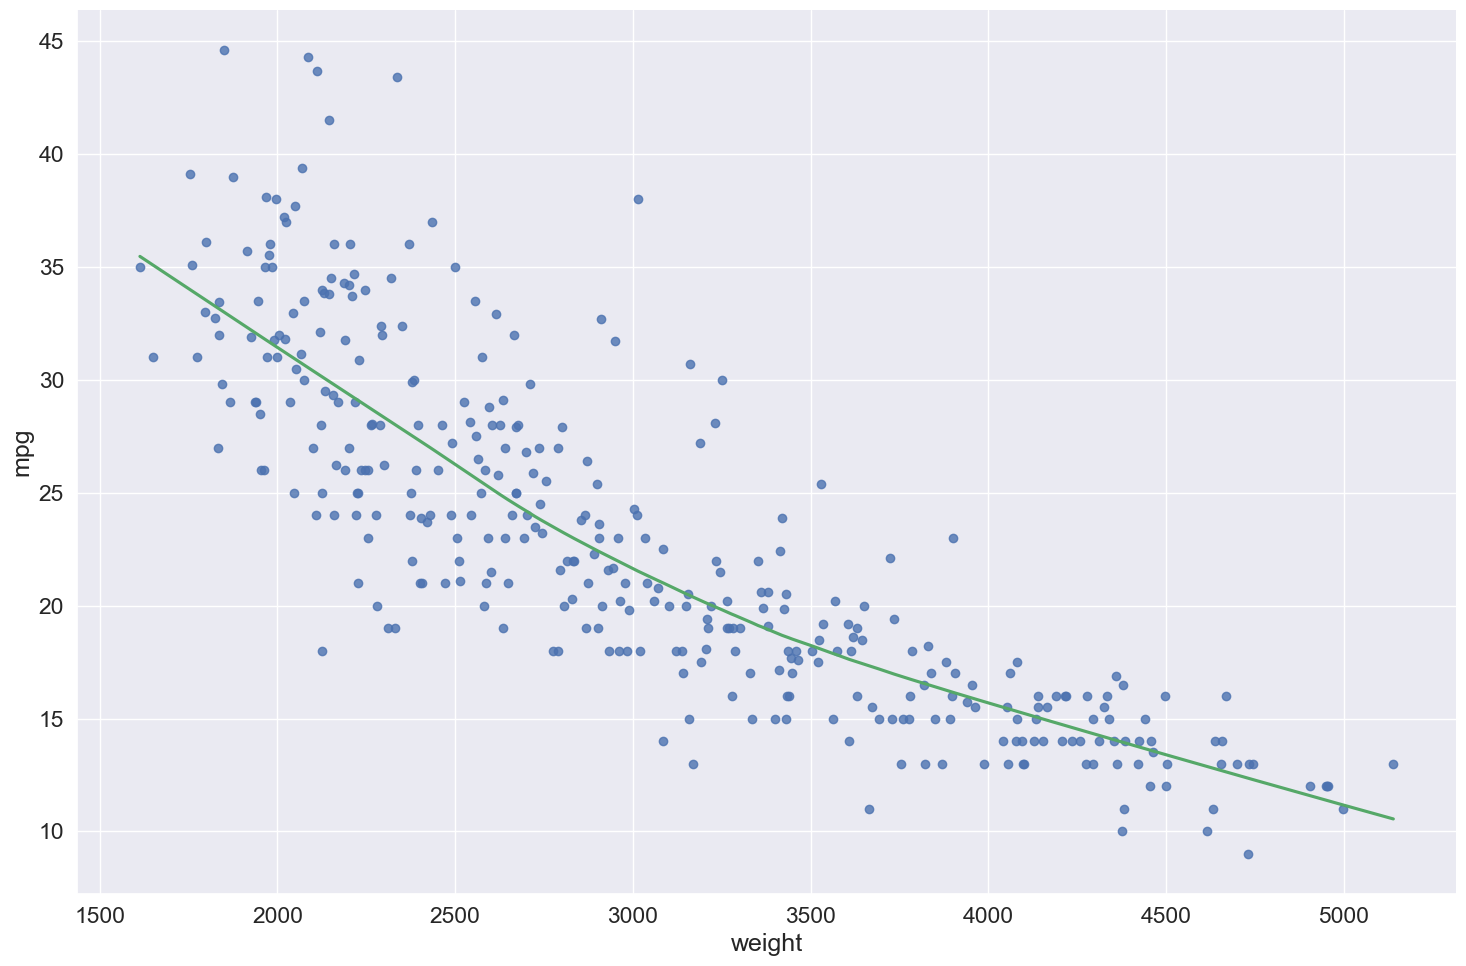

In [41]:
sns.set(font_scale=1.5)
sns.lmplot(x ='weight', y ='mpg', data = cars, height= 10, aspect= 1.5, line_kws={'color': 'g'}, lowess= True);

In [42]:
import plotly.express as px
gm = px.data.gapminder(year=2007)

In [43]:
gm.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.828,31889923,974.580338,AFG,4
23,Albania,Europe,2007,76.423,3600523,5937.029526,ALB,8
35,Algeria,Africa,2007,72.301,33333216,6223.367465,DZA,12
47,Angola,Africa,2007,42.731,12420476,4797.231267,AGO,24
59,Argentina,Americas,2007,75.320,40301927,12779.379640,ARG,32


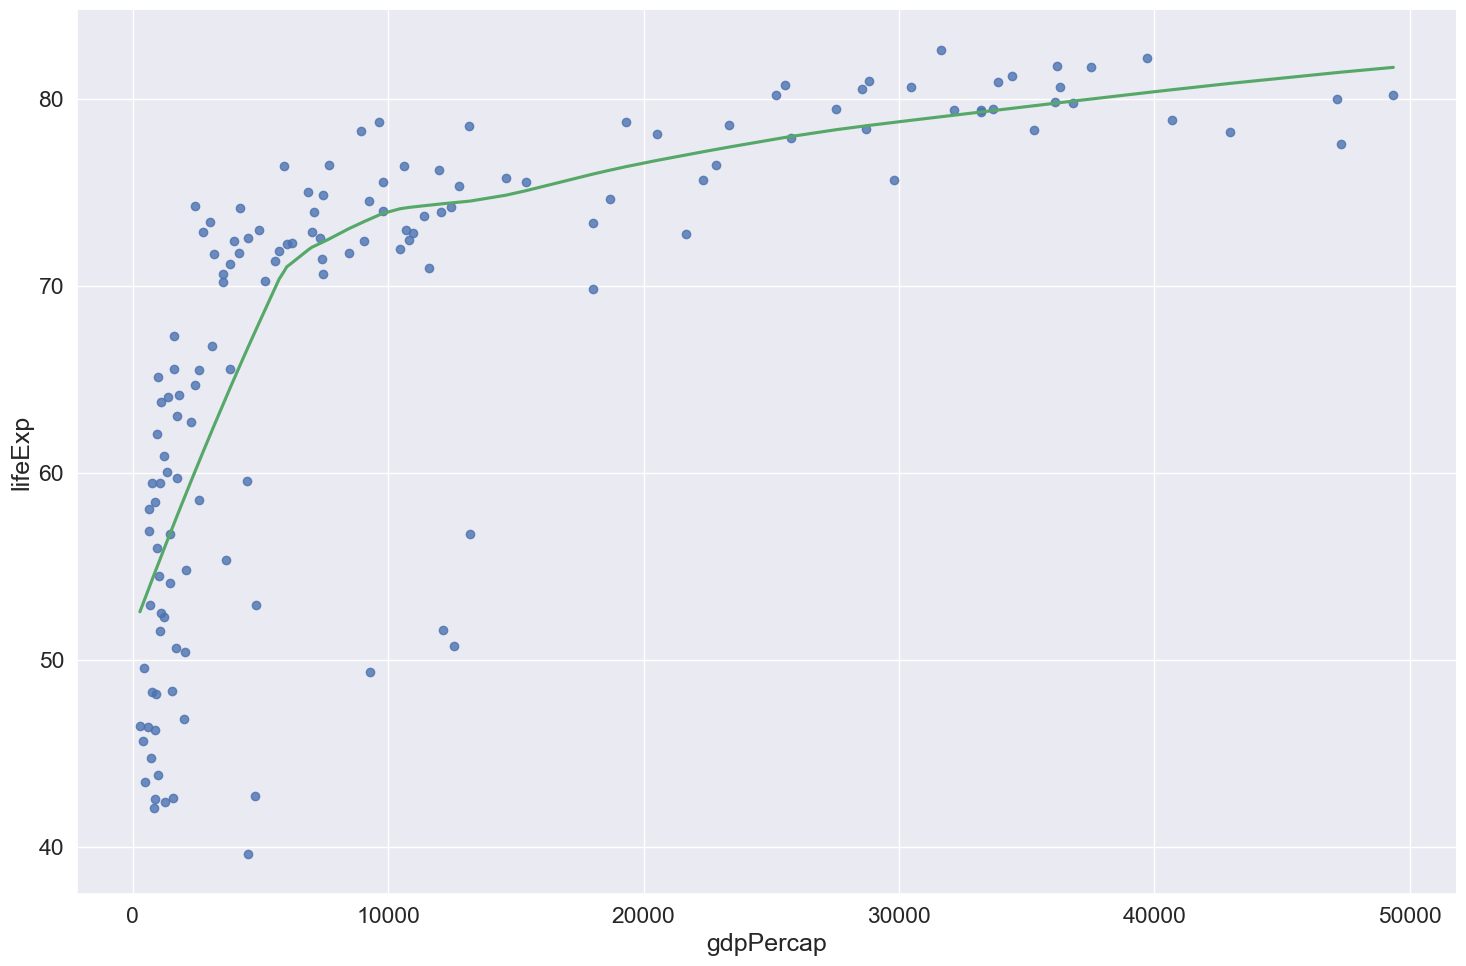

In [45]:
sns.set(font_scale=1.5)
sns.lmplot(x ='gdpPercap', y ='lifeExp', data = gm, height= 10, aspect= 1.5, line_kws={'color': 'g'}, lowess= True);

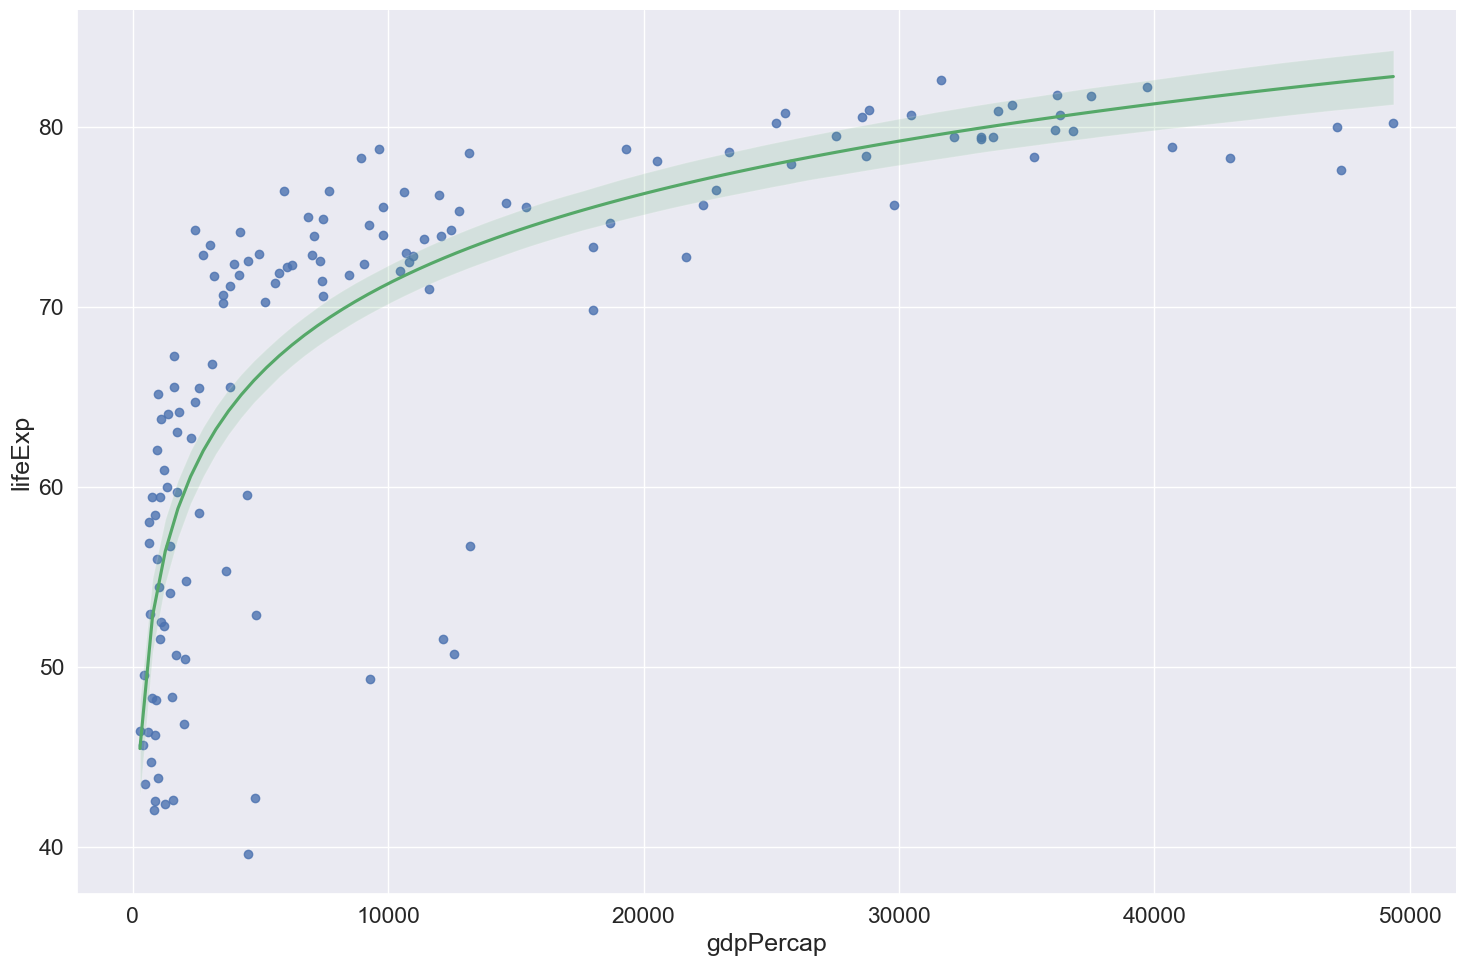

In [46]:
sns.set(font_scale=1.5)
sns.lmplot(x ='gdpPercap', y ='lifeExp', data = gm, height= 10, aspect= 1.5, line_kws={'color': 'g'}, logx= True);